In [74]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error

In [75]:
def bcf_to_twh(bcf, conversion_factor=0.293):
    """
    Converts natural gas volume from BCF to TWh.
    
    Parameters:
    - bcf (float): volume in billion cubic feet
    - conversion_factor (float): standard conversion factor (default: 0.293 TWh/BCF)
    
    Returns:
    - float: energy in TWh
    """
    return round(bcf * conversion_factor, 4)



In [76]:

# Natural Gas Production
raw_gas_production_df = pd.read_csv("https://ourworldindata.org/grapher/gas-production-by-country.csv?v=1&csvType=filtered&useColumnShortNames=true&time=earliest..2024&country=~COL&overlay=download-data", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})

# Natural Gas Consumption
raw_gas_consumption_df = pd.read_csv("https://ourworldindata.org/grapher/gas-consumption-by-country.csv?v=1&csvType=filtered&useColumnShortNames=true&tab=line&country=~COL&mapSelect=~COL&overlay=download-data", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})

# Natural Gas Trade (bcf)
raw_gas_trade_df = pd.read_csv("./data/raw/INT-Export-10-21-2025_21-19-22.csv", skiprows=1)

# Energy Consumption by Source
#raw_source_consumtion_df = pd.read_csv("https://ourworldindata.org/grapher/primary-sub-energy-source.csv?v=1&csvType=filtered&useColumnShortNames=true&country=~COL&overlay=download-data", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})

# Electricity Production by Sorce
#raw_source_production_df = pd.read_csv("https://ourworldindata.org/grapher/electricity-prod-source-stacked.csv?v=1&csvType=filtered&useColumnShortNames=true&country=~COL&overlay=download-data", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})

# Electricity Production by Sources in Percentages
raw_electricity_production_df = pd.read_csv("https://ourworldindata.org/grapher/share-elec-by-source.csv?v=1&csvType=filtered&useColumnShortNames=true&country=~COL&overlay=download-data")


In [77]:
gas_trade_df = raw_gas_trade_df.iloc[[2,4],2:].T.reset_index()
gas_trade_df.columns = ["Year", "imports", "exports"]
gas_trade_df.fillna(0, inplace=True)
gas_trade_df.Year = gas_trade_df.Year.astype(int)

In [78]:
rows_to_add = [{"Year": year, "imports": 0, "exports": 0} for year in range(1965, 1980)]

In [79]:
gas_trade_df = pd.concat([gas_trade_df, pd.DataFrame(rows_to_add)], ignore_index=True).sort_values(by="Year").reset_index(drop=True)
gas_trade_df.loc[len(gas_trade_df)] = [2024, 78.1465, 0.0] # Adding data for 2024, taken from here: https://www.elcolombiano.com/negocios/importacion-de-gas-natural-en-colombia-aumento-en-2024-pero-produccion-cae-HP27286357

gas_trade_df["imports_twh"] = gas_trade_df.imports.apply(bcf_to_twh)
gas_trade_df["exports_twh"] = gas_trade_df.exports.apply(bcf_to_twh)
gas_trade_df.drop(columns=["imports", "exports"], inplace=True)

In [80]:
gas_production_df = raw_gas_production_df[raw_gas_production_df["Year"] >= 1965 ][["Year", "gas_production__twh"]].copy()
gas_consumption_df = raw_gas_consumption_df[raw_gas_consumption_df["Year"] >= 1965 ][["Year", "gas_consumption_twh"]].copy()

gas_balance = gas_production_df.merge(gas_consumption_df, on="Year").merge(gas_trade_df, on="Year")

In [81]:
gas_balance

,Year,gas_production__twh,gas_consumption_twh,imports_twh,exports_twh
0,1965,11.378318,8.951250,0.0000,0.0000
1,1966,13.802176,9.336250,0.0000,0.0000
2,1967,14.455236,11.550000,0.0000,0.0000
3,1968,15.233884,11.771375,0.0000,0.0000
4,1969,16.803740,12.854188,0.0000,0.0000
5,1970,12.493251,12.493251,0.0000,0.0000
6,1971,13.004500,13.004500,0.0000,0.0000
7,1972,15.885500,15.885250,0.0000,0.0000
8,1973,16.460000,16.460000,0.0000,0.0000
9,1974,17.125500,17.125750,0.0000,0.0000


In [82]:
gas_balance.to_csv("./data/processed/gas_balance.csv", index=False)

In [83]:
electricity_production_df = raw_electricity_production_df.iloc[:, [2,4,5]]
electricity_production_df = electricity_production_df.fillna(0)

In [84]:
electricity_production_df.to_csv("./data/processed/electricity_production.csv", index=False)

# Predictions


In [85]:
training_df = gas_balance[gas_balance["Year"] < 2015][["Year", "gas_production__twh", "gas_consumption_twh"]]
test_df = gas_balance[gas_balance["Year"] >= 2015][["Year", "gas_production__twh", "gas_consumption_twh"]]

In [86]:
training_df

,Year,gas_production__twh,gas_consumption_twh
0,1965,11.378318,8.951250
1,1966,13.802176,9.336250
2,1967,14.455236,11.550000
3,1968,15.233884,11.771375
4,1969,16.803740,12.854188
5,1970,12.493251,12.493251
6,1971,13.004500,13.004500
7,1972,15.885500,15.885250
8,1973,16.460000,16.460000
9,1974,17.125500,17.125750


In [87]:
import warnings
warnings.filterwarnings("ignore", message="'force_all_finite'")

In [88]:
import numpy as np

# Time Series cross validation
tscv = TimeSeriesSplit(n_splits = 10)
errors = []

for train_index, test_index in tscv.split(training_df):
    train_set = training_df.iloc[train_index]
    test_set = training_df.iloc[test_index]

    y_train = train_set["gas_consumption_twh"]
    y_test = test_set["gas_consumption_twh"]

    # Ajustar un modelo ARIMA automáticamente al conjunto de entrenamiento
    model = auto_arima(
        y_train,
        seasonal=False,  # pon True si hay estacionalidad
        stepwise=True,
        suppress_warnings=True,
        error_action="ignore"
    )
    
    # Predecir para el tamaño del conjunto de test
    forecast = model.predict(n_periods=len(y_test))
    
    # Calcular error
    mae = mean_absolute_error(y_test, forecast)
    errors.append(mae)

    print(f"Train: {train_set['Year'].min()}–{train_set['Year'].max()} | "
          f"Test: {test_set['Year'].min()}–{test_set['Year'].max()} | MAE: {mae:.2f}")

print("\nAverage MAE across folds:", np.mean(errors))
    #print("TRAIN YEARS:", train_set["Year"].min(), "to", train_set["Year"].max(), "| TEST YEARS:", test_set["Year"].min(), "to", test_set["Year"].max())

Train: 1965–1974 | Test: 1975–1978 | MAE: 3.02
Train: 1965–1978 | Test: 1979–1982 | MAE: 2.72
Train: 1965–1982 | Test: 1983–1986 | MAE: 1.26
Train: 1965–1986 | Test: 1987–1990 | MAE: 3.20
Train: 1965–1990 | Test: 1991–1994 | MAE: 2.75
Train: 1965–1994 | Test: 1995–1998 | MAE: 10.71
Train: 1965–1998 | Test: 1999–2002 | MAE: 20.87
Train: 1965–2002 | Test: 2003–2006 | MAE: 2.43
Train: 1965–2006 | Test: 2007–2010 | MAE: 7.68
Train: 1965–2010 | Test: 2011–2014 | MAE: 9.82

Average MAE across folds: 6.44458922785396


In [89]:
y_training = training_df["gas_consumption_twh"]
y_testing = test_df["gas_consumption_twh"]

In [90]:
model1 = auto_arima(
        y_training,
        seasonal=False,
        stepwise=True,
        suppress_warnings=True,
        error_action="ignore"
    )

forecast = model1.predict(n_periods=len(y_testing))
    
mae = mean_absolute_error(y_testing, forecast)

print("Model 1 MAE:", mae)

Model 1 MAE: 16.60013788304521


In [91]:
from prophet import Prophet

prophet_df = gas_balance[["Year", "gas_consumption_twh"]].rename(columns={"Year": "ds", "gas_consumption_twh": "y"})

prophet_df["ds"] = pd.to_datetime(prophet_df["ds"], format="%Y")

# 4️⃣ Dividir entre train y test (por ejemplo, los últimos 5 años como test)
train = prophet_df[prophet_df["ds"].dt.year <= 2015]
test = prophet_df[prophet_df["ds"].dt.year > 2015]

In [95]:
# 5️⃣ Entrenar el modelo
model = Prophet(
    yearly_seasonality=False,  # ya que los datos son anuales
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='additive'
)
model.fit(train)

# 6️⃣ Hacer predicciones
future = model.make_future_dataframe(periods=len(test)+1, freq='Y')
forecast = model.predict(future)

19:52:46 - cmdstanpy - INFO - Chain [1] start processing
19:52:47 - cmdstanpy - INFO - Chain [1] done processing
c:\Projects\Colombian_energy_balance\colombian_energy_balance\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


C:\Users\keato\AppData\Local\Temp\ipykernel_21648\2229396307.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["ds"] = test["ds"].dt.to_period("Y").dt.to_timestamp()


MAE: 5.873387541351494


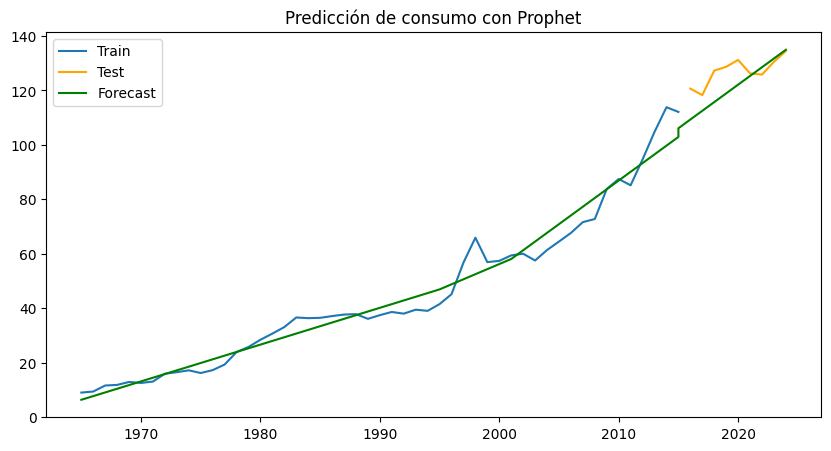

In [96]:
# 7️⃣ Evaluar desempeño
# Unir el test real con las predicciones
# Aseguramos que ambas fechas estén al inicio del año
forecast["ds"] = forecast["ds"].dt.to_period("Y").dt.to_timestamp()
test["ds"] = test["ds"].dt.to_period("Y").dt.to_timestamp()

# Ahora sí hacemos el join
pred = forecast.set_index('ds').loc[test['ds'], 'yhat']
mae = mean_absolute_error(test['y'], pred)
print("MAE:", mae)

# 8️⃣ Visualizar resultado
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train["ds"], train["y"], label="Train")
plt.plot(test["ds"], test["y"], label="Test", color="orange")
plt.plot(forecast["ds"], forecast["yhat"], label="Forecast", color="green")
plt.legend()
plt.title("Predicción de consumo con Prophet")
plt.show()

In [ ]:
test

,ds,y
